## Exercise 5-1: Warmup questions
***
1.  Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio
to 95%. How many dimensions will the resulting dataset have?
2.  Does it make any sense to chain two different dimensionality reduction algorithms?
3.  Compute the average distance of two points in a unit square. Test your result with a code
that uses random points.

## Exercise 5-2 Principal component analysis
***
Return to the halo catalogues from exercise sheet 1 (you can use the same notebook). Load the
halo catalogue and prepare the data for machine learning using the same pipelines, i.e. log halo
concentration is the label, and all other halo properties are the features.
1.  Train a random forest regressor
How long does it take to train it? You can use the time library of python. Evaluate the model
on the test set (root mean squared error between labels of test set and predictions).
2.  Use PCA to reduce the dimensionality with an explained variance ratio of 95%.
How many dimensions does the reduced dataset have?
3.  Train a random forest regressor on the reduced dataset How long does it take to train it?
Evaluate the model on the test set.


## Exercise 5-3 Manifold Learning
***
Same as 5.2, but now with Locally Linear Embedding (LLE), t-Distributed Stochastic Neighbor
Embedding (t-SNE), and Isomap.
1.  Use LLE to reduce the dimensionality. Test different numbers of dimensions for the manifold.
How does the timing compare to PCA? Does it give better predictions?
2.  Visualize your data with t-SNE. Use sklearn.manifold.TSNE to reduce your training set to 2
dimensions (this may take a few minutes). Then plot the results in a scatterplot using colors to
represent log halo concentration (i.e. the labels).
3.  Visualize your data with Isomap. Use sklearn.manifold.Isomap to reduce your training set to
2 dimensions (this may take a few minutes). Then plot the results in a scatterplot using colors
to represent log halo concentration (i.e. the labels).

***
# Solutions
***

## 5.1.i 
$$EVR = \frac{1}{1+\frac{\sum_\tilde{i} \lambda_\tilde{i}}{\sum_i \lambda_i }}$$
So, the number of PCA dimension for a given explained variance depends on the dataset. For a rough estimation, asssuming the dataset are completely random, we expect that all the eigenvalues have almost the same value, hence $\frac{\sum_\tilde{i} \lambda_\tilde{i}}{\sum_i \lambda_i } = \frac{D-M}{M}$, or $EVR = M/D$. Thus the resulting dimension is M = 0.95*D = 950.
## 5.1.ii
why not? 


## 5.1.iii
We want to compute the average distance of two random points inside a square, then what we basically compute is the following integral :
$$ E[dis]=\int_0^1 \int_0^1 \int_0^1\int_0^1 \sqrt{(x_1-x_2)^2+(y_1-y_2)^2} \,\,dx_1\,dx_2\,dy_1\,dy_2$$
The integral can be evaluated in Mathematica and the result is 
$$ E[dis] = 0.521405$$

### Average distance between two points using random point

In [1]:
import numpy as np
import random
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Generate two random number
dist= []
for i in range(1, 100000):
    r1 = np.array([random.random(), random.random()])
    r2 = np.array([random.random(), random.random()])
    dist.append(distance.euclidean(r1,r2))
    
average = np.mean(dist)
print(average)
    

0.5209501832822984


In [3]:
# DIstribution of the distance of two random number in a box

Estimate $\pi$ using Random Number

In [4]:
inside = 0
outside =100000
for i in range(1,outside):
    r = np.array([random.uniform(-1,1), random.uniform(-1,1)])
    if np.linalg.norm(r)<=1:
        inside = inside+1
pi = 4*inside/outside
print(pi)

3.14372


***
# 5.2 Dimensionaloty Reductions
***

In [5]:
import numpy as np
import time 
import pandas as pd

In [6]:
# Loading data
dataset = np.genfromtxt("hlist_1.00035.list", comments="#", max_rows=20000)

#Features
virial_mass   = np.log10(dataset[:,10])
virial_radius = np.log10(dataset[:,11])
concentration = np.log10(dataset[:,11] / dataset[:,12]) #Concentration is virial radius divided by scale length
velocity_disp = np.log10(dataset[:,13])
vmax          = np.log10(dataset[:,16])
spin          = np.log10(dataset[:,26])
b_to_a        = dataset[:,44]
c_to_a        = dataset[:,45]
energy_ratio  = dataset[:,54]
peak_mass     = np.log10(dataset[:,58])
peak_vmax     = np.log10(dataset[:,60])
halfmass_a    = dataset[:,61]
peakmass_a    = dataset[:,67]
acc_rate      = dataset[:,64]

#Create Panda dataframe 
halos = pd.DataFrame({"concentration": concentration,'Virial Mass':virial_mass,"Virial Radius" : virial_radius, "vmax":vmax,
    "spin": spin, "velocity_disp" : velocity_disp, "Energi Ratio" : energy_ratio, "peak mass" : peak_mass,
    "half mass" : halfmass_a})

halos.head()

,concentration,Virial Mass,Virial Radius,vmax,spin,velocity_disp,Energi Ratio,peak mass,half mass
0,1.001863,14.215638,3.054453,2.978815,-1.611899,2.984820,0.6102,14.215638,0.4023
1,0.699512,14.201124,3.049566,2.915458,-1.189297,2.947919,0.6324,14.201124,0.5043
2,0.889922,14.058426,3.001994,2.902775,-1.469160,2.907191,0.5770,14.058426,0.4803
3,0.479754,13.987175,2.978264,2.832106,-1.099578,2.879302,0.7308,13.987175,0.6403
4,0.898464,13.930796,2.959464,2.866689,-1.587707,2.872739,0.5982,13.930796,0.4864


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e01018128>,
      dtype=object)

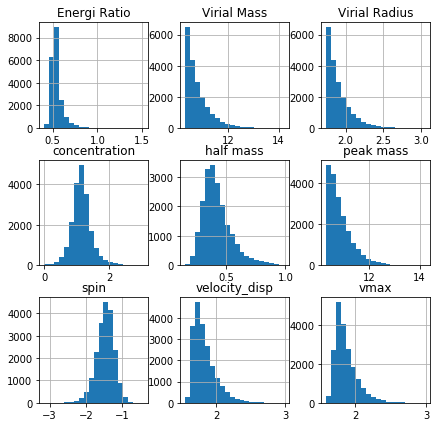

In [7]:
#Histogram to see the distribution of features
hist = halos.hist(bins=20,figsize=[7,7])
hist

In [32]:
########### Pipeline for Data preprocessing ############
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

# custom trasnformer class
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_list):
        self.feature_list = feature_list
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        return X[self.feature_list]
    
#Atributes for minmax scaling, see the histogram
minmax_list = ['Virial Radius', 'Virial Mass','peak mass']
#attributes for standard scaling, see the histogram
st_list = ["vmax", "spin", "velocity_disp", "Energi Ratio" , "half mass"]

#label-feature split
halos_copy= halos.copy()
X= halos_copy.drop(["concentration"], axis=1)
y=halos_copy["concentration"]

#split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Combine feature selection, imputer , and scaling
prep_pipe = FeatureUnion([
                    ("mm_scaler", Pipeline([
                        ("mm_selector", FeatureSelector(minmax_list)), ("mm_imputer", Imputer(strategy="median"))])),
                    ("st_scaler",Pipeline([
                        ("st_selector", FeatureSelector(st_list)), ("st_imputer", Imputer(strategy="median"))]))
                    ])

X_train_prep= prep_pipe.fit_transform(X_train)

### 5.2.1 Training Random Forest Regressor

In [33]:
####### Training time for Random forest regressor ###########
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor()
#timer start
start= time.time()
RF.fit(X_train_prep, y_train)

#timer end
elaps= time.time()-start
print(f"Time taken to train: {elaps}")

Time taken to train: 1.5844182968139648


In [36]:
#### MSE error on test set###
X_test_prep=prep_pipe.fit_transform(X_test)

MSE = np.sqrt(np.mean((RF.predict(X_test_prep)-y_test)**2
        ))
print(f"RMSE error : {MSE}")

RMSE error : 0.14061059940312032


In [37]:
report = pd.DataFrame({"RF predictions" : RF.predict(X_test_prep), "Target": y_test})
report.head()

,RF predictions,Target
12007,1.050261,1.121487
12936,1.366301,1.216309
4445,0.986553,0.749802
16804,1.358486,1.444971
8236,1.026260,0.990036


### 5.2.2 DImensionality Reduction with PCA

In [39]:
from sklearn.decomposition import PCA
pca_pipe= PCA(n_components=3)
pca_pipe.fit(X_train_prep)
print("Number of components : 3")
print(f"explained variance ratio: {np.sum(pca_pipe.explained_variance_ratio_)} ")

Number of components : 3
explained variance ratio: 0.9731574384949303 


In [40]:
####### Training time for Random forest regressor with PCA ###########
X_train_PCA=pca_pipe.fit_transform(X_train_prep)
#timer start
start= time.time()
RF.fit(X_train_PCA, y_train)

#timer end
elaps= time.time()-start
print(f"Time taken to train: {elaps}")

Time taken to train: 0.7173597812652588


In [44]:
#### MSE error on test set###
X_test_pca=pca_pipe.fit_transform(X_test_prep)
RF_pca=RandomForestRegressor()
RF_pca.fit(X_train_PCA, y_train)
MSE_pca = np.sqrt(np.mean((RF_pca.predict(X_test_pca)-y_test)**2
        ))
print(f"RMSE error : {MSE_pca}")

RMSE error : 0.48143664046351964


In [46]:
report_PCA = pd.DataFrame({"RF with PCA predictions" : RF_pca.predict(X_test_pca), "Target": y_test})
report_PCA.head()

,RF with PCA predictions,Target
12007,1.039922,1.121487
12936,1.230198,1.216309
4445,1.094156,0.749802
16804,0.866720,1.444971
8236,1.987476,0.990036


***
# 5.3 Manifold Learning
***
### Locally Linear Embedding

In [47]:
from sklearn.manifold import LocallyLinearEmbedding, TSNE, isomap
lla_pipe= LocallyLinearEmbedding(n_components=3)
lla_pipe.fit(X_train_prep)
X_train_lla = lla_pipe.fit_transform(X_train_prep)
print("Number of components : 3")


Number of components : 3


In [48]:
#### MSE error on test set###
X_test_lla=lla_pipe.fit_transform(X_test_prep)
RF_lla=RandomForestRegressor()
RF_lla.fit(X_train_lla, y_train)
MSE_lla = np.sqrt(np.mean((RF_lla.predict(X_test_lla)-y_test)**2
        ))
print(f"RMSE error : {MSE_lla}")

RMSE error : 0.5069379152599116


### t SNE 

In [50]:
tsne_pipe=TSNE(n_components=2)
X_train_tsne=tsne_pipe.fit_transform(X_train)

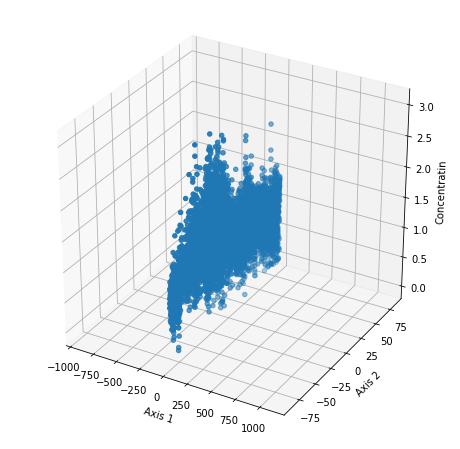

In [65]:
%matplotlib inline
from mpl_toolkits import mplot3d
fig=plt.figure(figsize=[8,8])
ax=plt.axes(projection='3d', )
zline = y_train
xline = X_train_tsne[:, 0]
yline = X_train_tsne[:,1]
ax.scatter3D(xline, yline, zline)
ax.set_xlabel("Axis 1")
ax.set_ylabel("Axis 2")
ax.set_zlabel("Concentratin")
ax.set_xbound([-1000, 1200])
ax.view_init()

### Isomap

In [57]:
from sklearn.manifold import Isomap
iso_pipe=Isomap(n_components=2)
X_train_iso=iso_pipe.fit_transform(X_train)

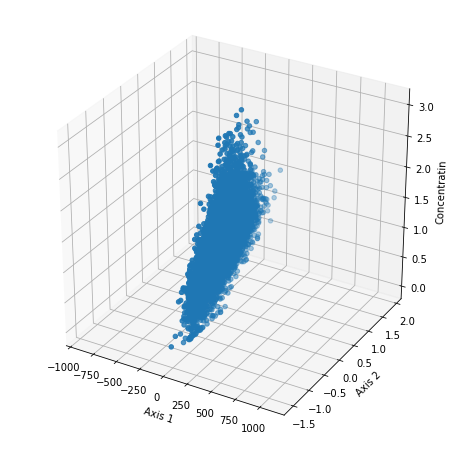

In [66]:
%matplotlib inline
from mpl_toolkits import mplot3d
fig=plt.figure(figsize=[8,8])
ax=plt.axes(projection='3d', )
zline = y_train
xline = X_train_iso[:, 0]
yline = X_train_iso[:,1]
ax.scatter3D(xline, yline, zline)
ax.set_xlabel("Axis 1")
ax.set_ylabel("Axis 2")
ax.set_zlabel("Concentratin")
ax.set_xbound([-1000, 1200])
ax.view_init()